### 0. Environment Setup

In [2]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

### 1. Data Preparation

In [3]:
import data.data_loader as loader

# loader.store_data()

In [4]:
data = loader.data_preprocess()
data.head()

KeyboardInterrupt: 

### 3. Graphic Representation of the datasets

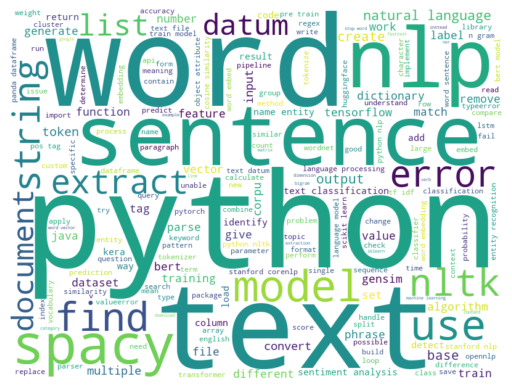

In [ ]:
import data.data_analysis as analysis

analysis.word_cloud_for_title(data)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

vectorizer = TfidfVectorizer(max_df=0.85)
tfidf = vectorizer.fit_transform(data['cleaned_title'])

feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# create a dictionary mapping each term to its IDF score.
idf_dict = dict(zip(feature_names, idf_scores))

# sort the terms based on the IDF scores (lowest first).
sorted_terms = sorted(idf_dict.items(), key=lambda item: item[1])
#print(sorted_terms)

# for term, score in sorted_terms:
#     if score > 10:
#         print(term, score)

# create custom stop words list to add those terms with low IDF score (threshold < 3.5)
custom_stop_words = []
for term, score in sorted_terms:
    if score <= 3.5:
        custom_stop_words.append(term)

# again perform stop word removal
def custom_stop_word_removal(text):
    tokens = word_tokenize(text)
    text = [word for word in tokens if word.lower() not in custom_stop_words]
    text = " ".join(text)
    return text

data['cleaned_title'] = data['cleaned_title'].apply(custom_stop_word_removal)

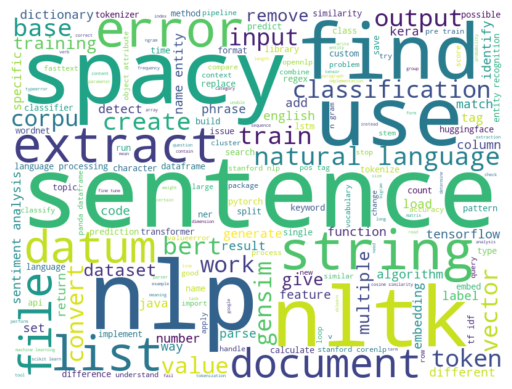

In [ ]:
updated_text = " ".join(word for word in data['cleaned_title'])
updated_wordc = WordCloud(width = 800, height = 600, background_color='white').generate(updated_text)
plt.figure()
plt.imshow(updated_wordc, interpolation="bilinear")
plt.axis("off")
plt.show()

### 4. Posts Caterogisation


##### **Initial Thought of Categorisation**

Based on our analysis of the assignment scenario and Stack Overflow posts, we have the initial thought of categorising the posts according to key pipeline stages such as Data Reading and Formatting, Data Preprocessing, Feature Engineering, Model Selection/Training, and Performance Evaluation with each stage further refined by specific keywords. It is because real-world issues are typically addressed through projects that progress in distinct stages, these are the stages that every developers would face when they are working on NLP projects. This structure assist developers to quickly identify and locate the problems relevant to each phase of a project, hence searching relevant posts and answers in the system more efficiently. To ensure that our classification captures the underlying themes, we plan to validate our approach using topic modeling techniques like LDA, k-means, and BERTopic, providing a solid, data-driven foundation for our design.

##### **Topic Modelling - Latent Dirichlet Allocation (LDA)**

LDA is one of the most popular unsupervised topic modelling techniques discovering topics naturally through patterns of the clustering of data (Tahaei, Vaniea & Saphra 2020, p.3) in large volume. It uses word frequencies and co-occurrence frequencies in the documents to build probablistic models that unveil the hidden semantic structures of text (Croft et al. 2022, p.10). Although LDA provides effective way to analyse the entire corpus, the model itself still lacks of syntax and semantics in its topics (Tahaei, Vaniea & Saphra 2020, p.10) as it could only suggest high-level group of wordings instead of details of interest. Nevertheless, the ability to automatically identify topics and cluster them to show trend in the data would be a good starting point for determining the catergorisation strategy while also potentially provide supprort evidence to the catergorisation.

In the below, LDA is adopted with both count vectors and tf-idf representation to reveal different dimensions of topic structure in data. The count-vector approach is a bag-of-words model which count the the raw frequency of words. And tf-idf reweights the data by down-weighting common terms and up-weighting rare words that exist rarely in posts. This might enable us to find interesting and discriminative topics that are easy to be overlooked by raw counts.

In [ ]:
# LDA topic modelling with count vectors

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

LDA_count_vectorizer = CountVectorizer(max_df=0.85)
LDA_count = LDA_count_vectorizer.fit_transform(data['cleaned_text'])

lda_count = LatentDirichletAllocation(n_components=15, random_state=42) # ensure reproducibility
lda_count.fit(LDA_count)

feature_names_count = LDA_count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_count.components_):
    top_words = [feature_names_count[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: nltk, sentence, pos, tag, word
Topic 1: text, line, datum, label, file
Topic 2: gram, vector, similarity, document, feature
Topic 3: dataset, datum, training, train, model
Topic 4: face, huggingface, fine, tokenizer, model
Topic 5: use, text, user, api, question
Topic 6: extract, word, frequency, count, text
Topic 7: embed, vector, input, model, word
Topic 8: want, like, string, list, word
Topic 9: extract, ner, name, spacy, entity
Topic 10: file, dataframe, datum, column, text
Topic 11: matrix, gensim, term, topic, document
Topic 12: noun, stanford, parse, language, sentence
Topic 13: get, run, code, try, error
Topic 14: good, like, text, sentence, word


The LDA with count vector gives us the top five words of each topic as we think displaying the top 5 would be informative enough in providing high-level thematic insights. Since LDA gives different results every time we run, a random seed = 42 is set to ensure the reproducibility of results. For example, words in topic 10 (e.g. file, dataframe, datum, column, text) may be issues related to data reading and formatting. Also, wordings in topic 0 and 9 (e.g. nltk, pos, spacy, ner, entity) are common terms we see in data preprocessing stage. Further, words in topic 3 and 13 (e.g. training, train, try, error) are terms we usually see in Model Training and Testing stage. To conclude, the LDA using bad-of-words model provide certain level of evidence to support the categorisation design of ours.

In [ ]:
# LDA topic modelling with tf-idf

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# convert text into tf-idf matrix
LDA_tf_vectorizer = TfidfVectorizer(max_df=0.85) # ignore words appear >85% in documents to reduce very common words
LDA_tfidf = LDA_tf_vectorizer.fit_transform(data['cleaned_text'])

# initialise LDA model
lda_tf = LatentDirichletAllocation(n_components=15, random_state=42) # ensure reproducibility   
lda_tf.fit(LDA_tfidf)

feature_names_tf = LDA_tf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_tf.components_):
    top_words = [feature_names_tf[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: install, attributeerror, attribute, import, error
Topic 1: bertopic, lda, coherence, mallet, topic
Topic 2: deberta, smooth, deeppavlov, freqdist, bleu
Topic 3: sgd, acc, singularize, automodelforsequenceclassification, elmo
Topic 4: adapter, dynet, biobert, scispacy, bla
Topic 5: model, run, try, file, error
Topic 6: vbd, dt, jj, nnp, nn
Topic 7: bert, datum, error, train, model
Topic 8: like, list, sentence, text, word
Topic 9: noun, stanford, tag, sentence, entity
Topic 10: hunspell, chocolate, roc, codec, sentiwordnet
Topic 11: tp, tflearn, fn, fp, nmf
Topic 12: onnx, audio, triple, bengali, predicate
Topic 13: seller, deepspeech, synonymous, jwnl, verbnet
Topic 14: senna, subtree, abstractive, meteor, rouge


LDA with tf-idf does not work well for providing insights on categorization. The tf-idf weighting tends to emphasize on rare words that might be mispelled and not carrying any useful information, which result in several noisy and fragmented topics (e.g. topic 3 and 6). The topics and wordings are not providing meaningful insights compared to the bag-of-word appraoch.

##### **Document Clustering - K-means Clustering**

Clustering has been recognised as one of the simplest and important upsupervised data mining techniques in text categorisation, summarization and classification (Alhawarat & Hegazi 2018). K-means clustering is a partitioning method that we specify the number of clusters before performing clustering. Random initial centers are chosen based on the chosen number of clusters, and the objects are assigned to the nearest center with the least Euclidean distance. It therefore groups documents based on the similarity of the numerical representations (e.g. tf-idf or word embeddings). Documents within a cluster are likely to share common keywords, making the interpretation of topic in a simple way. The capability, simplicity and efficiecny of k-means clustering might help in identifying thematic groupings that support our categorization. 

In the below, k-means clustering is performed on both tf-idf and Word2Vec as we want to explore different aspects of the text and grab a more complementary insights. TF-IDF highlights differences in term frequency with the emphasis on rare/distinct vocabulary patterns, while Word2Vec captures semantic relationships and contextutal similarity among words. The number of clusters for both methods are set to 15 as we think it would be informative enough while maintaining consistency with other methods.


In [ ]:
# K-means clustering with tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# convert text into tf-idf matrix
k_vectorizer = TfidfVectorizer(max_df=0.85)  # ignore words appear >85% in documents to reduce very common words
k_tfidf = k_vectorizer.fit_transform(data['cleaned_text'])

# initialise k-means clustering model with specified number of clusters
kmeans = KMeans(n_clusters=15, random_state=42) # ensure reproducibility
kmeans.fit(k_tfidf)

# 
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = k_vectorizer.get_feature_names_out()

for i in range(15):
    top_terms = [terms[ind] for ind in order_centroids[i, :5]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

Cluster 0: document, similarity, term, topic, word
Cluster 1: language, natural, processing, english, text
Cluster 2: noun, phrase, verb, extract, sentence
Cluster 3: feature, text, word, model, datum
Cluster 4: model, train, training, bert, datum
Cluster 5: column, dataframe, row, panda, text
Cluster 6: entity, name, ner, spacy, recognition
Cluster 7: vector, embed, word, embedding, layer
Cluster 8: word, list, like, text, string
Cluster 9: sentiment, analysis, negative, positive, review
Cluster 10: sentence, word, like, text, list
Cluster 11: error, try, code, get, run
Cluster 12: text, like, want, use, try
Cluster 13: file, text, line, code, python
Cluster 14: tag, pos, tagger, word, nltk


The result present distinct clusters clearly grouping related terms. For instance, clusters related to formatting (e.g. "column, dataframe, row, panda, text"), preprocessing (e.g. "tag, pos, tagger, word, nltk" and "entity, name, ner, spacy, recognition"), feature enginnering (e.g. "vector, embed, word, embedding, layer") and model training ("model, train, training, bert, datum" and "sentiment, analysis, negative, positive, review") provide non-overlapping thematic insights to support the categorization pipeline.

In [ ]:
# K-means clustering with Word2Vec

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

tokenized_docs = [word_tokenize(doc.lower()) for doc in data['cleaned_text']]
k_word2vec = Word2Vec(tokenized_docs)

def compute_doc_vectorise(docs, model):
    doc_embeddings = []
    for tokens in docs:
        # Collect vectors for tokens that exist in the model's vocabulary
        vectors = [model.wv[token] for token in tokens if token in model.wv]
        if vectors:
            # Compute the mean vector for the document
            avg_vec = np.mean(vectors, axis=0)
        else:
            # If no tokens are found in the vocabulary, return a zero vector
            avg_vec = np.zeros(model.vector_size)
        doc_embeddings.append(avg_vec)
    return np.array(doc_embeddings)

vectorized_docs = compute_doc_vectorise(tokenized_docs, model=k_word2vec)


kmeans_word2vec = KMeans(n_clusters=15, random_state=42) # ensure reproducibility
cluster_labels = kmeans_word2vec.fit(vectorized_docs)

for i in range(15):
    tokens_per_cluster = []
    most_representative = k_word2vec.wv.most_similar(positive=[cluster_labels.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster.append(t[0])
    print(f"Cluster {i}: {', '.join(tokens_per_cluster)}")

NameError: name 'data' is not defined

The k-means clustering with Word2Vec results show several clusters with ambiguous, unrelated or mixed terms. This is most likely due to the averaging of word embeddings to form document vectors, which dilutes the contextual and semantic signals. These wordings especially adjectives do not directly map to the proposed categorisataion pipeline stages. The inconsistency makes it difficult to use the clusters result as a basis for categorisation. 

##### **Topic Labelling - BERTopic**

In [ ]:
# !pip install bertopic
# !pip install tf-keras

In [ ]:
# topic Labelling - BERTopic

from bertopic import BERTopic
import tf_keras as keras
import warnings
warnings.filterwarnings("ignore")

topic_model = BERTopic(nr_topics=10)
topics, probs = topic_model.fit_transform(data['cleaned_text'])

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9385,-1_word_text_model_sentence,"[word, text, model, sentence, like, try, use, ...",[implement multi label text classifier keras t...
1,0,7140,0_word_text_sentence_like,"[word, text, sentence, like, want, try, exampl...",[detect sentence simmilar meaning syllable wor...
2,1,1838,1_model_bert_train_word,"[model, bert, train, word, embed, embedding, t...",[obtain bert sentence embedding vector module ...
3,2,1106,2_error_try_model_code,"[error, try, model, code, run, get, import, fo...",[try train model intent recognition get float ...
4,3,326,3_dataframe_column_row_word,"[dataframe, column, row, word, spark, panda, p...",[add column dataframe pyspark new pyspark try ...
5,4,99,4_json_format_file_convert,"[json, format, file, convert, expect, maltpars...",[spacy possible convert json format biluo sche...
6,5,37,5_countvectorizer_count_word_scikit,"[countvectorizer, count, word, scikit, sklearn...",[sklearn countvectorizer custom vocabulary set...
7,6,32,6_emoji_emoticon_unicode_tweet,"[emoji, emoticon, unicode, tweet, emojis, sent...",[add emoji keras tokenizer api twitter sentime...
8,7,23,7_imbalance_smote_class_dataset,"[imbalance, smote, class, dataset, oversample,...",[remove minority class certain number example ...
9,8,14,8_convert_number_value_write,"[convert, number, value, write, way, string, n...",[convert number english string website like tr...


In [ ]:
# dig deeper into topic -1 (outliers group)

subset_topic_negative_1 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == -1]

subset_negative_1_topic_model = BERTopic(nr_topics=10)
subset_topics_negative_1, subset_probs_negative_1 = subset_negative_1_topic_model.fit_transform(subset_topic_negative_1)

subset_negative_1_topic_model.get_topic_info()

9673


,Topic,Count,Name,Representation,Representative_Docs
0,-1,5343,-1_word_text_model_sentence,"[word, text, model, sentence, like, use, try, ...",[structure text feed pipeline ner build ner na...
1,0,2199,0_word_sentence_text_like,"[word, sentence, text, like, want, find, use, ...",[want extract text value text spacy new spacy ...
2,1,826,1_error_try_run_code,"[error, try, run, code, model, spacy, file, ge...",[import google colab follow import work get er...
3,2,516,2_model_layer_train_input,"[model, layer, train, input, datum, keras, tra...",[update fine tune model train model dataset tr...
4,3,502,3_dataframe_column_row_panda,"[dataframe, column, row, panda, word, list, te...",[match dataframe add result column panda follo...
5,4,121,4_embedding_embed_word_vector,"[embedding, embed, word, vector, sentence, glo...",[embedding train sentence sentence model train...
6,5,86,5_file_word_folder_chinese,"[file, word, folder, chinese, text, character,...",[txt file python code write code try pick line...
7,6,54,6_tokenizer_bert_token_wordpiece,"[tokenizer, bert, token, wordpiece, tokenizati...",[padding huggingface tokenizer work try follow...
8,7,16,7_tagger_pos_memory_stanford,"[tagger, pos, memory, stanford, tag, slow, mb,...",[lingpipe pos tagger run memory have trouble l...
9,8,10,8_numpy_array_loop_element,"[numpy, array, loop, element, dot, index, prod...",[group numpy array element loop text processin...


In [1]:
# dig deeper into topic 0

subset_topic_0 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == 0]

subset_0_topic_model = BERTopic(nr_topics=10)
subset_topics_0, subset_probs_0 = subset_0_topic_model.fit_transform(subset_topic_0)

subset_0_topic_model.get_topic_info()

NameError: name 'data' is not defined

In [ ]:
subset_0_topic_model.get_topic_info(7)

,Topic,Count,Name,Representation,Representative_Docs
0,7,38,7_plot_word_frequency_graph,"[plot, word, frequency, graph, axis, ggplot, y...",[plot word topic stm possible plot word topic ...


In [ ]:
# dig deeper into topic 1

subset_topic_1 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == 1]

subset_1_topic_model = BERTopic(nr_topics=10)
subset_topics_1, subset_probs_1 = subset_1_topic_model.fit_transform(subset_topic_1)

subset_1_topic_model.get_topic_info()

1479


,Topic,Count,Name,Representation,Representative_Docs
0,-1,105,-1_word_model_embed_input,"[word, model, embed, input, layer, vector, dat...",[r combine embed lstm network plan use skip gr...
1,0,504,0_bert_model_sentence_error,"[bert, model, sentence, error, fine, use, try,...",[fine tune bert model context specific embeddi...
2,1,454,1_word_vector_embed_model,"[word, vector, embed, model, embedding, train,...",[add word embed gensim model look way dinamica...
3,2,160,2_probability_gram_word_model,"[probability, gram, word, model, language, sen...",[compute probability sentence vocabulary word ...
4,3,68,3_transformer_model_training_train,"[transformer, model, training, train, datum, c...",[train mask language model big text gb pytorch...
5,4,54,4_glove_word_vector_embedding,"[glove, word, vector, embedding, file, embed, ...",[use glove word embed non english text try run...
6,5,52,5_save_model_loss_train,"[save, model, loss, train, training, checkpoin...",[save train transformer model train transforme...
7,6,33,6_hug_face_model_huggingface,"[hug, face, model, huggingface, trainer, train...",[reinitialize weight hug face llama model offi...
8,7,31,7_attention_head_layer_self,"[attention, head, layer, self, shape, matrix, ...",[attention calculation matrix level confuse ca...
9,8,18,8_perplexity_calculate_language_model,"[perplexity, calculate, language, model, metri...",[calculate perplexity model train gensim model...


### Reference

Alhawarat, M & Hegazi, M 2018, 'Revisiting k-means and topic modeling, a comparison study to cluster arabic documents', IEEE Access, 6, pp. 42740-42749, DOI: 10.1109/ACCESS.2018.2852648

Tahaei, M, Vaniea, K & Saphra, N 2020, Understanding Privacy-Related Questions on Stack Overflow. in CHI '20: Proceedings of the 2020 CHI Conference on Human Factors in Computing Systems., 639, ACM, ACM CHI Conference on Human Factors in Computing Systems, Honolulu, Hawaii, United States, 25/04/20. <https://doi.org/10.1145/3313831.3376768>

Croft, R, Xie, Y, Zahedi, M, Babar MA & Treude, C 2022,'An empirical studyof developers’d iscussions about security challenges of diﬀerent programming languages', Empirical Software Engineering, 27, pp. 1-52, DOI: https://doi.org/10.1007/s10664-021-10054-w


Topic Modelling using LDA - count vecto

https://medium.com/@prashanthsri12/topic-modeling-in-python-using-latent-dirichlet-allocation-lda-61001ba51124